<a href="https://colab.research.google.com/github/rosselladedo/DOG_BREEDS_SEARCH_ENGINE/blob/main/NoIndexSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import time
import itertools
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import traceback
import sys
import sklearn
import random as rand
import ipywidgets

from IPython.display import display

from ipywidgets import HBox, Image, HTML

from sklearn import metrics
from sklearn.preprocessing import normalize

from random import random
from numpy.linalg import norm
from IPython.display import display
from keras.models import Model
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.auto import tqdm
from PIL import Image, ImageDraw

# tensorflow version 2.4.0
from tensorflow import keras

In [ ]:
DOGS_BREEDS = 120
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

In [ ]:
#data directories
BASE_DIR = "/content/gdrive/Shareddrives/MIRCV"
IMAGES_DIR = "/content/gdrive/MyDrive/MIRCV"
FEATURES_FINETUNED_CONCATENATE_DIR = "/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_concatenate_predict.npz"
FEATURES_NM_CONCATENATE_DIR = "/content/gdrive/Shareddrives/Dataset/Features/features_NM_concatenate_predict.npz"

QUERY_ESTERNA = "/content/gdrive/Shareddrives/MIRCV/Foto_Esterne"

TEST_PATH = os.path.join(BASE_DIR, "TestSet")
DOGS_IMAGES_DIRECTORIES_PATH = os.path.join(IMAGES_DIR, "images/Images")
ALL_IMAGES_DIR = "/content/gdrive/Shareddrives/MIRCV/All_Images"
NOISE_DIR = "/content/gdrive/Shareddrives/MIRCV/mirflickr25k"
QUERY_DIR = "/content/gdrive/Shareddrives/MIRCV/query"

In [ ]:
def take_features(path = FEATURES_NM_CONCATENATE_DIR):
  #path = "/content/gdrive/Shareddrives/MIRCV/Features/features_nome_correct_predict.npz"
  features_path = np.load(path, allow_pickle=True)
  features = features_path['arr_0']
  return features

In [ ]:
#model
pretrained_model = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

pretrained_model.summary()

In [ ]:
#query extraction feature

def extract_features_query(img):
  query_features = []
  image_path = os.path.join(ALL_IMAGES_DIR, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_np = tf.keras.preprocessing.image.img_to_array(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = pretrained_model(image_np).numpy()
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/MIRCV/Features/features_query.npz", query_features)

In [ ]:
#query extraction feature

def extract_features_query_predict(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  #image_path = os.path.join (QUERY_ESTERNA, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = pretrained_model.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_query_predict.npz", query_features)

In [ ]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_execution(q_features_path = "/content/gdrive/Shareddrives/Dataset/Features/features_query_predict.npz"):

  result_euclidean = []

  q_features = take_features(q_features_path)
  q_name = q_features[0][0]
  q_features = q_features[0][1]
  print(q_name)
  features = take_features()

  q_features = normalize(q_features, axis=1)
  
  for item in tqdm(features):
    feat = item[1]
    name = item[0]

    feat = normalize(feat, axis=1)

    dist = np.linalg.norm(feat - q_features, axis=1)

    res = (np.double(dist), name)

    result_euclidean.append(res)

  ranking = sorted(result_euclidean)
  
  return ranking[:10]

In [ ]:
def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)

In [ ]:
def unpad_image(image_pil):
  """ Removes white borders of the given PIL Image. """
  image_np = np.array(image_pil)
  rr, cc = np.nonzero((image_np != 255).any(axis=2))
  y0, y1 = rr.min(), rr.max()
  x0, x1 = cc.min(), cc.max()
  return image_pil.crop((x0, y0, x1, y1))


def make_image_grid(image_paths, relevance=None, rows=3, cols=8, thumbnail_size=(100, 100)):
  """ Makes a grid of images.
  Args:
    - image_paths (list): a list of image paths
    - relevance (list): if not None, indicates whether to add a green or red
                        indicator on each image.
    - rows, cols (int): the number of rows/cols of the image grid.
    - thumbnail_size (tuple): size of a cell as a (width, height) tuple.
  Returns:
    - grid (PIL.Image): the grid as a PIL Image.
  """
  cell_width, cell_height = thumbnail_size
  grid = Image.new('RGB', (cell_width * cols, cell_height * rows), color='white')
  draw = ImageDraw.Draw(grid)
  relevance = (None,) * len(image_paths) if relevance is None else relevance

  cells = itertools.product(range(rows), range(cols))  # every (row, col) combination
  for (row, col), image_path, rel in zip(cells, image_paths, relevance):
    #print(image_path)
    if not os.path.exists(image_path):
      image_path = os.path.join(TEST_PATH, "n02086910_2035.jpg")
    image_pil = Image.open(image_path).convert('RGB')
    image_pil = unpad_image(image_pil)
    image_pil.thumbnail(thumbnail_size)

    cell_x = cell_width * col + (cell_width - image_pil.width) // 2
    cell_y = cell_height * row + (cell_height - image_pil.height) // 2
    grid.paste(image_pil, (cell_x, cell_y))

    if rel is not None:
      color = 'green' if rel else 'red'
      x0 = cell_width * col + 5
      y0 = cell_height * (row + 1) - 3
      x1 = cell_width * (col + 1) - 5
      y1 = cell_height * (row + 1)
      draw.rectangle([x0, y0, x1, y1], fill=color)

  return grid

def display_results(query_image, ranks, mAP_vector, limit=10):
  """ Draws results of image searches.
  Args:
    - ranks (ndarray): a (Q,N)-shaped matrix of indices of retrieved elements
                       for each query, already ranked. E.g., ranks[0, 4] is the
                       index of fifth retrieved element with respect to query #0.
    - groundtruth (ndarray): a (Q,N)-shaped boolean matrix indicating relevance
                             of database elements to queries, i.e., if
                             groundtruth[3,2] is True, then the database element
                             #2 is relevant to the query #3.
    - queries_annot (pandas.DataFrame): information about queries.
    - db_annot (pandas.DataFrame): information about database elements.
    - limit (int): the number of top results to show.
  """
  
  nq = len(ranks)
  image_paths = []
  image_relevance = []

  image_paths.append(os.path.join(TEST_PATH, query_image))
  image_relevance.append( None )
  
  counter = 0

  for rank in ranks:

    image_paths.append(os.path.join(ALL_IMAGES_DIR, rank[1]))
    image_relevance.append(mAP_vector[counter])

    counter = counter + 1

  grid = make_image_grid(image_paths, image_relevance, rows=nq, cols=limit+1)
  display(grid)

In [ ]:
def return_rank_mAP(query, rank):
  mAP_vector = []
  query_label = query.split("_")[0]

  for dog in rank:
    result_label = dog[1].split("_")[0]
    if query_label == result_label:
      mAP_vector.append(1)
    else:
      mAP_vector.append(0)
      
  return mAP_vector

In [ ]:
def search_and_print(image_name, QUERY_TIMES_PRETRAINED):
  
  print("image name query: " + str(image_name))
  extract_features_query_predict(image_name)

  starting_time = time.time()
  result_rank = query_execution()
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))
  QUERY_TIMES_PRETRAINED.append(query_execution_time)

  mAP_vector = return_rank_mAP(image_name, result_rank)
  display_results(image_name, result_rank, mAP_vector)
  
  return result_rank

In [ ]:
#n02106662_4059.jpg = Pastore tedesco scelto per consegna
query_img = "n02106662_4059.jpg"

image name query: n02106662_4059.jpg
n02106662_4059.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.585132122039795


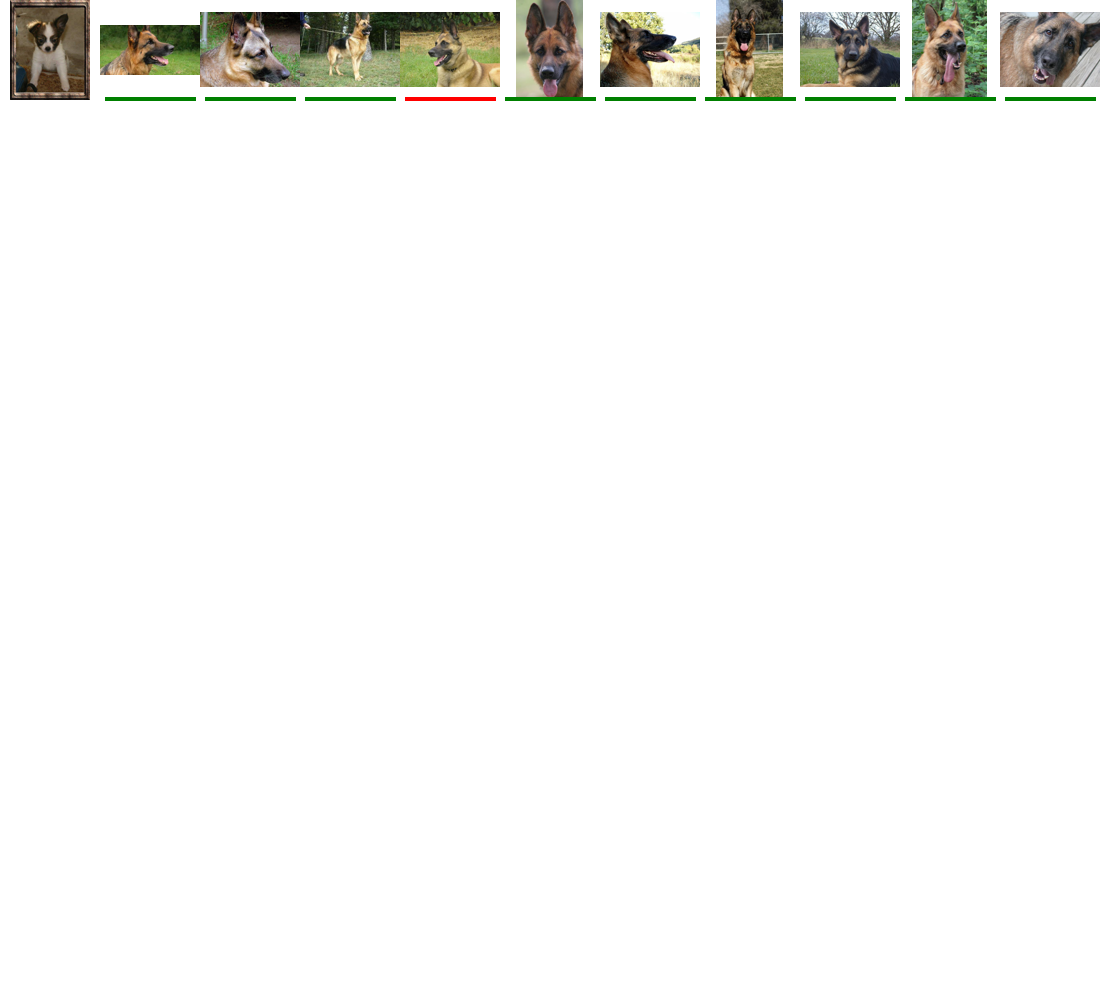

In [ ]:
vec=[]
res = search_and_print(query_img,vec)

# **mAP**

In [ ]:
def mAP_calculation(query_img, num_dogs_performance = 10):
  query_label = query_img.split("_")[0]
  results = res   #search_and_print(0, "n02085620_1455.jpg")
  
  denom = num_dogs_performance

  mAP = 0

  for r in results:
    if num_dogs_performance == 0:
      break

    result_label = r[1].split("_")[0]

    if query_label == result_label:
      mAP = mAP + 1

    num_dogs_performance = num_dogs_performance -1

  mAP = mAP/denom
  print("mAP: " + str(mAP))

mAP_calculation(query_img)

mAP: 0.9


# **FINETUNED MODEL**

In [ ]:
def take_finetuned_features(path = FEATURES_FINETUNED_CONCATENATE_DIR):
  #path = "/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_nome_correct_predict.npz"
  features_path = np.load(path, allow_pickle=True)
  features = features_path['arr_0']
  return features

In [ ]:
model = keras.models.load_model('/content/gdrive/Shareddrives/MIRCV/Models/Fine_Tuning_Model6_Flatten_512120_LR0001')

finetuned_model = keras.models.Model(inputs=model.input, outputs=model.get_layer('flatten').output)
finetuned_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
#query extraction feature

def extract_finetuned_features_query(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  #image_feature_vector = finetuned_model(image_np).numpy()
  image_feature_vector = finetuned_model.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_query_predict.npz", query_features)

In [ ]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_finetuned_execution(q_features_path = "/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_query_predict.npz"):

  result_euclidean = []

  q_features = take_finetuned_features(q_features_path)
  q_name = q_features[0][0]
  q_features = q_features[0][1]
  features = take_finetuned_features()

  q_features = normalize(q_features, axis=1)
  
  for item in tqdm(features):
    feat = item[1]
    name = item[0]

    feat = normalize(feat, axis=1)

    dist = np.linalg.norm(feat - q_features, axis=1)

    res = (np.double(dist), name)

    result_euclidean.append(res)

  ranking = sorted(result_euclidean)
  
  return ranking

In [ ]:
def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)

In [ ]:
def unpad_image(image_pil):
  """ Removes white borders of the given PIL Image. """
  image_np = np.array(image_pil)
  rr, cc = np.nonzero((image_np != 255).any(axis=2))
  y0, y1 = rr.min(), rr.max()
  x0, x1 = cc.min(), cc.max()
  return image_pil.crop((x0, y0, x1, y1))


def make_image_grid(image_paths, relevance=None, rows=1, cols=8, thumbnail_size=(100, 100)):
  """ Makes a grid of images.
  Args:
    - image_paths (list): a list of image paths
    - relevance (list): if not None, indicates whether to add a green or red
                        indicator on each image.
    - rows, cols (int): the number of rows/cols of the image grid.
    - thumbnail_size (tuple): size of a cell as a (width, height) tuple.
  Returns:
    - grid (PIL.Image): the grid as a PIL Image.
  """
  cell_width, cell_height = thumbnail_size
  grid = Image.new('RGB', (cell_width * cols, cell_height * rows), color='white')
  draw = ImageDraw.Draw(grid)
  relevance = (None,) * len(image_paths) if relevance is None else relevance

  cells = itertools.product(range(rows), range(cols))  # every (row, col) combination
  for (row, col), image_path, rel in zip(cells, image_paths, relevance):
    #print(image_path)
    image_pil = Image.open(image_path).convert('RGB')
    image_pil = unpad_image(image_pil)
    image_pil.thumbnail(thumbnail_size)

    cell_x = cell_width * col + (cell_width - image_pil.width) // 2
    cell_y = cell_height * row + (cell_height - image_pil.height) // 2
    grid.paste(image_pil, (cell_x, cell_y))

    if rel is not None:
      color = 'green' if rel else 'red'
      x0 = cell_width * col + 5
      y0 = cell_height * (row + 1) - 3
      x1 = cell_width * (col + 1) - 5
      y1 = cell_height * (row + 1)
      draw.rectangle([x0, y0, x1, y1], fill=color)

  return grid

def display_results(query_image, ranks, mAP_vector, limit=10):
  """ Draws results of image searches.
  Args:
    - ranks (ndarray): a (Q,N)-shaped matrix of indices of retrieved elements
                       for each query, already ranked. E.g., ranks[0, 4] is the
                       index of fifth retrieved element with respect to query #0.
    - groundtruth (ndarray): a (Q,N)-shaped boolean matrix indicating relevance
                             of database elements to queries, i.e., if
                             groundtruth[3,2] is True, then the database element
                             #2 is relevant to the query #3.
    - queries_annot (pandas.DataFrame): information about queries.
    - db_annot (pandas.DataFrame): information about database elements.
    - limit (int): the number of top results to show.
  """
  
  nq = len(ranks)
  image_paths = []
  image_relevance = []

  image_paths.append(os.path.join(TEST_PATH, query_image))
  image_relevance.append( None )
  
  counter = 0

  for rank in ranks:

    image_paths.append(os.path.join(ALL_IMAGES_DIR, rank[1]))
    image_relevance.append(mAP_vector[counter])

    counter = counter + 1

  grid = make_image_grid(image_paths, image_relevance, rows=nq, cols=limit+1)
  display(grid)

In [ ]:
def return_rank_mAP(query, rank):
  mAP_vector = []
  query_label = query.split("_")[0]

  for dog in rank:
    result_label = dog[1].split("_")[0]
    if query_label == result_label:
      mAP_vector.append(1)
    else:
      mAP_vector.append(0)
      
  return mAP_vector

In [ ]:
def search_and_print_finetuned(image_name, QUERY_TIMES_FINETUNED):
  
  print("image name query: " + str(image_name))
  extract_finetuned_features_query(image_name)

  starting_time = time.time()
  result_rank = query_finetuned_execution()
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))
  QUERY_TIMES_FINETUNED.append(query_execution_time)

  mAP_vector = return_rank_mAP(image_name, result_rank)
  display_results(image_name, result_rank[:10], mAP_vector)

  return result_rank

In [ ]:
query_img = "n02087046_224.jpg"

In [ ]:
res = search_and_print_finetuned(query_img)

## **mAP CALCULATION**

In [ ]:
def mAP_calculation(res, query_img, num_dogs_performance = 5):
  query_label = query_img.split("_")[0]
  results = res   #search_and_print(0, "n02085620_1455.jpg")
  
  denom = num_dogs_performance

  mAP = 0

  for r in results:

    if num_dogs_performance == 0:
      break
    if r == None:
      break

    result_label = r[1].split("_")[0]
    #print(result_label)

    if query_label == result_label:
      mAP = mAP + 1

    num_dogs_performance = num_dogs_performance -1

  mAP = mAP/denom
  
  return mAP

# **EXECUTION OF QUERIES**

In [ ]:
def plot_query_map(QUERY_MAP_PRETRAINED, QUERY_MAP_FINETUNED):

  K = 50
  
  avg_map_pretrained = []
  avg_map_finetuned = []
  
  avg_map_pretrained = np.mean(QUERY_MAP_PRETRAINED, axis = 0)
  avg_map_finetuned = np.mean(QUERY_MAP_FINETUNED, axis = 0)

  x = np.array(range(1, K))
  
  y_ft = np.array(avg_map_finetuned)
  y_pt = np.array(avg_map_pretrained)

  plt.title("mAP comparison")

  plt.plot(x, y_pt)
  plt.plot(x, y_ft)

  plt.legend(["mAP pretrained", "mAP finetuned","mAP pretrained + index", "mAP finetuned + index"])

  plt.figure()

In [ ]:
def plot_query_times(num_of_queries,QUERY_TIMES_PRETRAINED, QUERY_TIMES_FINETUNED):

  plt.title(f"Query time using brute force or LSH index on {num_of_queries} 5-NN queries")

  x_bf = np.array(range(1,num_of_queries+1))
  y_bf = np.array(QUERY_TIMES_PRETRAINED)

  x_lsh = np.array(range(1,num_of_queries+1))
  y_lsh = np.array(QUERY_TIMES_FINETUNED)

  plt.plot(x_bf, y_bf)
  plt.plot(x_lsh, y_lsh)

  plt.legend(["Brute Force", "LSH"])
  plt.figure()

image name query: n02097474_5007.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


n02097474_5007.jpg


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.330512046813965


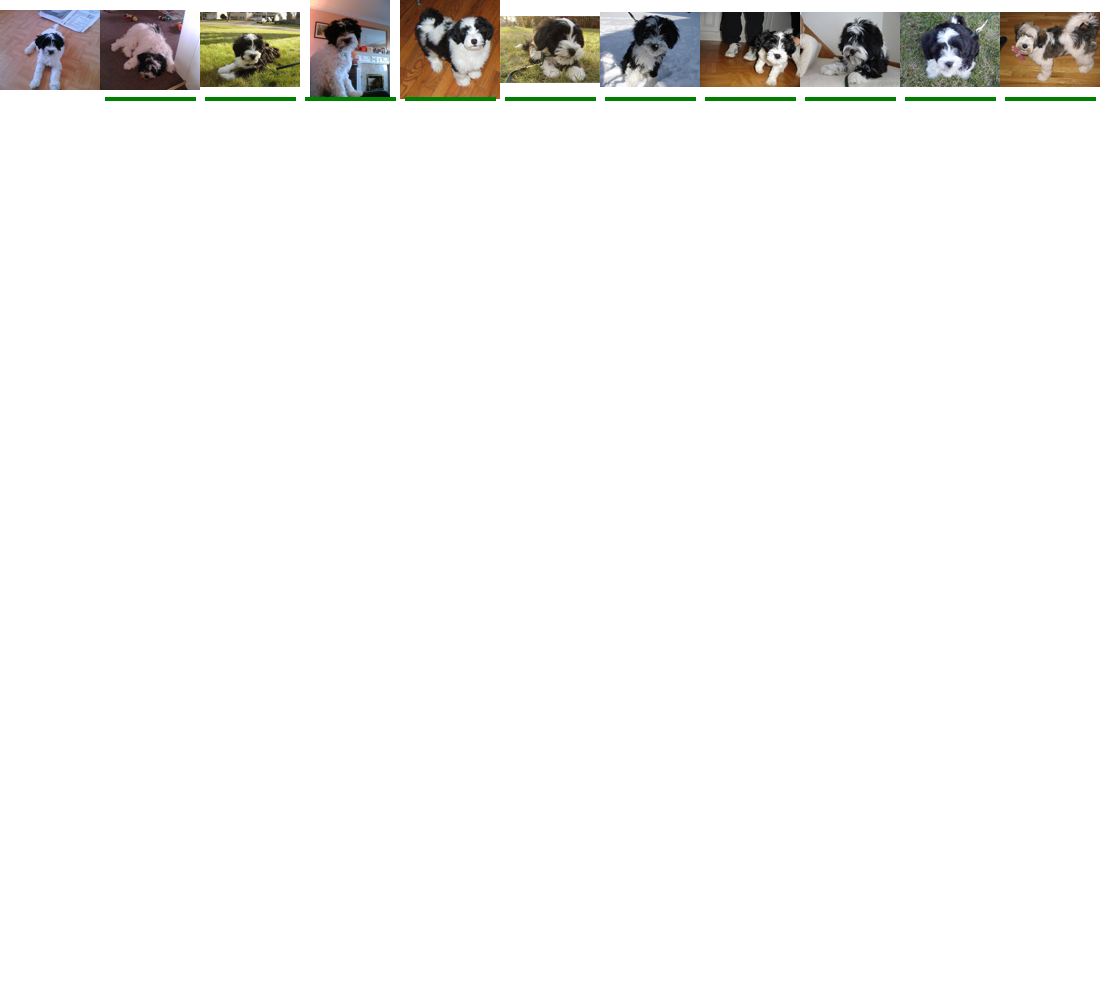

image name query: n02097474_5007.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 10.917309999465942


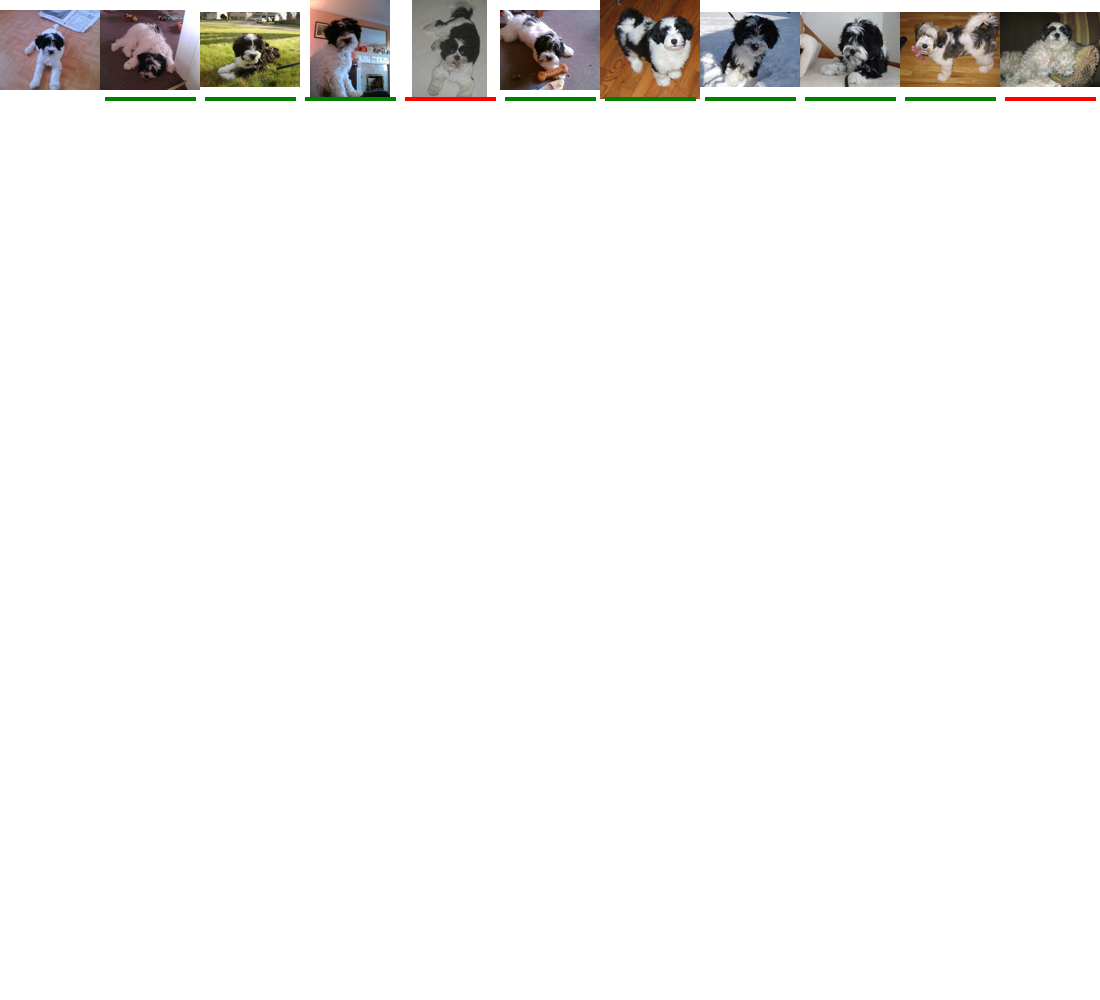

image name query: n02105641_1505.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


n02105641_1505.jpg


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 7.71898627281189


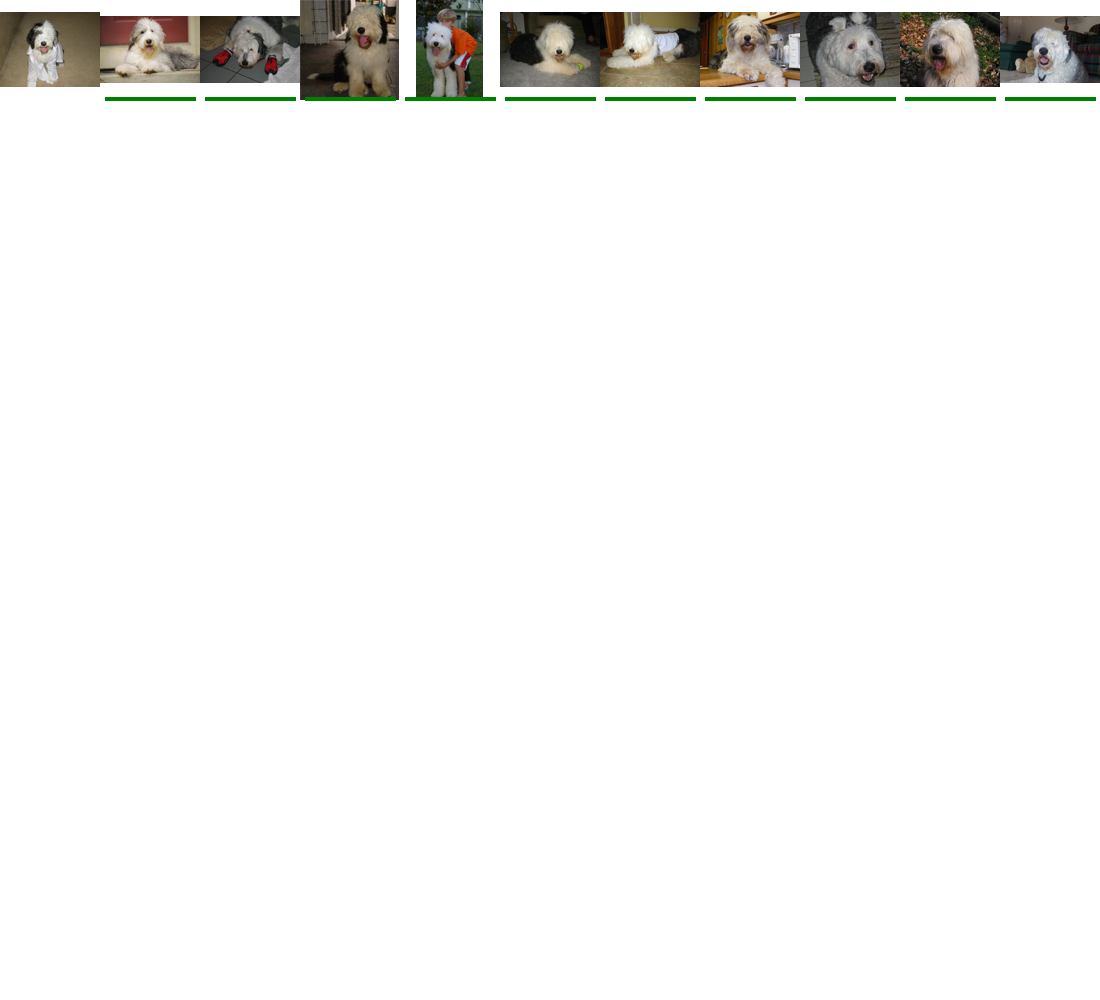

image name query: n02105641_1505.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 7.680516719818115


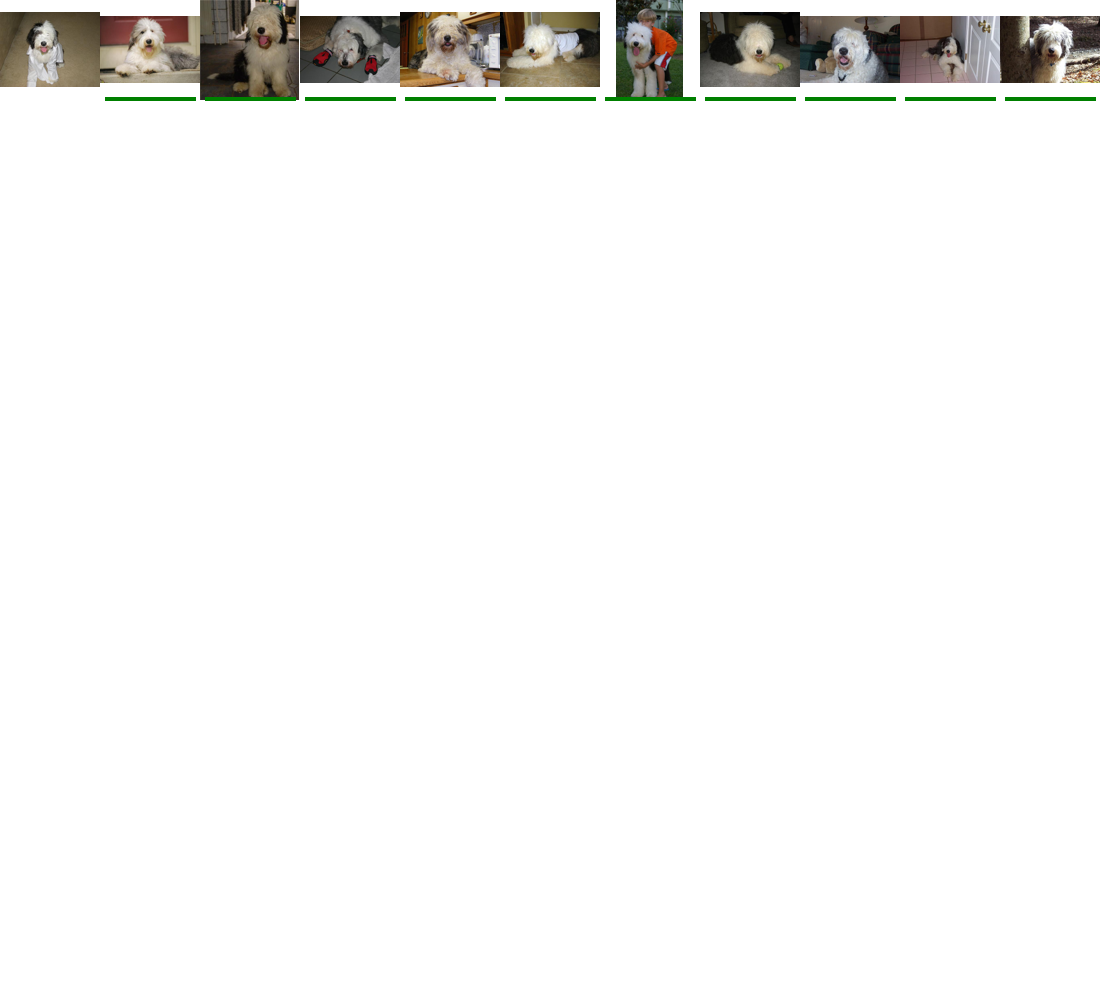

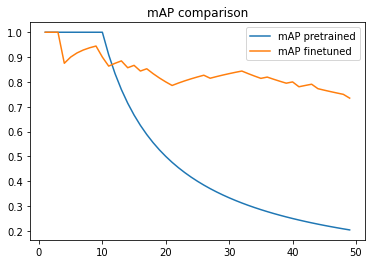

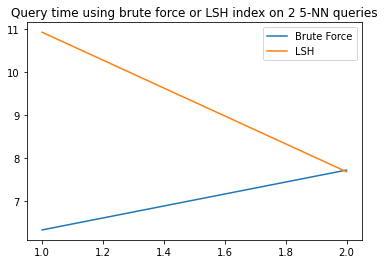

<Figure size 432x288 with 0 Axes>

In [ ]:
def query_loop_execution(num_of_queries):

  query_extracted = rand.sample(os.listdir(TEST_PATH), num_of_queries)

  QUERY_TIMES_PRETRAINED = []
  QUERY_MAP_PRETRAINED = []
  QUERY_TIMES_FINETUNED = []
  QUERY_MAP_FINETUNED = []

  K = 50

  for query_img in query_extracted: 
    res = search_and_print(query_img, QUERY_TIMES_PRETRAINED)
    MAP = []
    for i in range(1, K):
      MAP.append(mAP_calculation(res, query_img, i))
    QUERY_MAP_PRETRAINED.append(MAP)

    res = search_and_print_finetuned(query_img, QUERY_TIMES_FINETUNED)
    MAP = []
    for i in range(1, K):
      MAP.append(mAP_calculation(res, query_img, i))
    QUERY_MAP_FINETUNED.append(MAP)

  plot_query_map(QUERY_MAP_PRETRAINED, QUERY_MAP_FINETUNED)
  plot_query_times(num_of_queries, QUERY_TIMES_PRETRAINED, QUERY_TIMES_FINETUNED)

query_loop_execution(2)